## Topic Modelling

We have downloaded some speeches by B. Obama and M. Romney made during US Presidential election 2012. The speeches are uploaded on GitHUB and we would try to find some imortant topics each of their speeches consisted of. We will do Topic modelling using Gensim and visualize these topics using a womderful package called pyLDAvis.

In [138]:
# Find folders and text under a given path
import os

# For dataframe/tables
import pandas as pd
import numpy as np

# Default dictionary and counter
from collections import defaultdict, Counter

# Gensim
from gensim import corpora
from gensim import models

# Model evaluation
from gensim.models import CoherenceModel

# Suppress deprecation and future warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Visualization - plots, word cloud and LDA visualization
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()


In [2]:
# corpus folder
folder = 'tmp'

# Corpus 
corpus_bow = dict()

# Load the corpus
for fld in next(os.walk(folder))[1] :
    for corpus in os.listdir(folder + os.sep + fld):
        file = os.getcwd() + os.sep + folder + os.sep + fld + os.sep + corpus
        if os.path.splitext(file)[1] == '.mm' :
            corpus_bow[fld] = list(corpora.mmcorpus.MmCorpus(file))            

# dictionary 
for item in next(os.walk(folder))[2] :
    file = os.getcwd() + os.sep + folder + os.sep + item
    if os.path.splitext(file)[1] == '.dict' :        
        corpus_dict = corpora.Dictionary.load(file)


In [3]:
# Transform corpus to Tf-idf
corpus_tfidf = dict()
for fld in corpus_bow.keys() :    
    Tfidf = models.TfidfModel(corpus_bow[fld], smartirs='ntc')
    corpus_tfidf[fld] = Tfidf[corpus_bow[fld]]    


In [4]:
#corpus_dict[id]
textlist = dict()
for fld in corpus_tfidf.keys() :
    textlist[fld] = [[corpus_dict[text_tup[0]] for text_tup in doc for _ in range(int(text_tup[1]))] for doc in corpus_bow[fld]]

In [50]:
# LDA model - evaluate coherence for different number of topics
num_of_passes = 10
x = defaultdict(list); y = defaultdict(list); z = defaultdict(list)
for fld in corpus_tfidf.keys() :
    for num_topics in range(5,20,1) :
        lda_model = models.LdaModel(corpus_tfidf[fld], id2word=corpus_dict, num_topics=num_topics, passes = num_of_passes,\
                                  chunksize=100, random_state=123, update_every=1)
        coherence_model_lda = CoherenceModel(model=lda_model,texts = np.squeeze(textlist[fld]), dictionary=corpus_dict, coherence='c_v')
        coherence_score = coherence_model_lda.get_coherence()        
        x[fld].append(num_topics) ; y[fld].append(coherence_score)
        print("{}'s speech : Number of topics is {}, coherence score is {}".format(fld,num_topics,coherence_score))


romney's speech : Number of topics is 5, coherence score is 0.6574311275799759
romney's speech : Number of topics is 6, coherence score is 0.6401647326180719
romney's speech : Number of topics is 7, coherence score is 0.5200713283513657
romney's speech : Number of topics is 8, coherence score is 0.6605303988906828
romney's speech : Number of topics is 9, coherence score is 0.6503916687668478
romney's speech : Number of topics is 10, coherence score is 0.5686472461172393
romney's speech : Number of topics is 11, coherence score is 0.5856653088456653
romney's speech : Number of topics is 12, coherence score is 0.6063284790387485
romney's speech : Number of topics is 13, coherence score is 0.5489878571824715
romney's speech : Number of topics is 14, coherence score is 0.5864512111727479
romney's speech : Number of topics is 15, coherence score is 0.5586578044480234
romney's speech : Number of topics is 16, coherence score is 0.5365315182261232
romney's speech : Number of topics is 17, coh

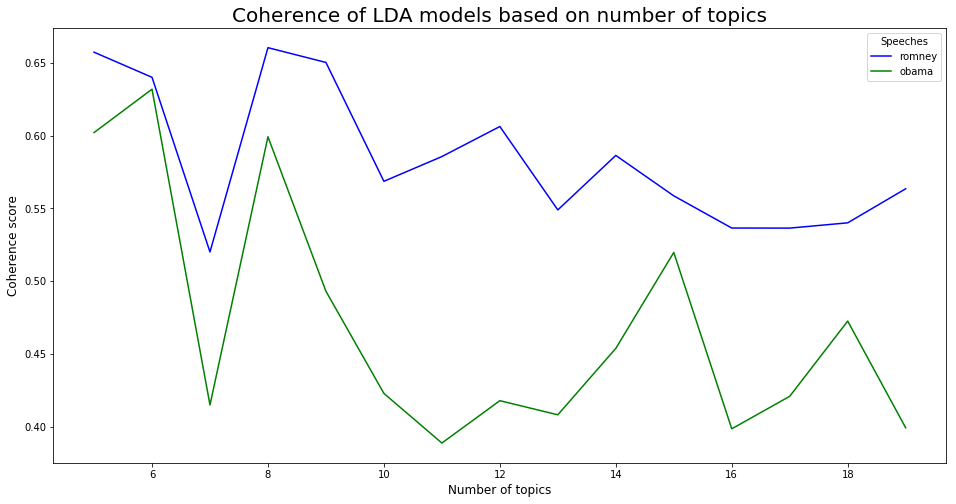

In [51]:
# Plot the coherence
plt.figure(figsize=(16,8))
col = dict()
col['obama'] = 'green'; col['romney'] = 'blue'
for fld in corpus_tfidf.keys() :
    plt.plot(x[fld],y[fld], color=col[fld], label=fld)
plt.legend(title='Speeches')
plt.title("Coherence of LDA models based on number of topics", fontsize=20)
plt.ylabel("Coherence score",fontsize=12)
plt.xlabel("Number of topics",fontsize=12)
plt.show()

## Analysis of Romney's speeches

In [249]:
# Train LDA model and find the model perplexity
def train_LDA_model(fld) :
    lda = dict(); num_topics = dict()
    lda[fld] = models.LdaModel(corpus_tfidf[fld], id2word=corpus_dict, num_topics=num_topics[fld], passes = num_of_passes,\
                                chunksize=100, random_state=123, update_every=1)
    model_perplexity = lda_model.log_perplexity(corpus_tfidf[fld])
    print("Model perplexity for {} is {}".format(fld,model_perplexity))


In [251]:
# LDA - final model (Romney's speech)
fld = 'romney'
num_of_passes = 10
lda = dict(); num_topics = dict()
num_topics[fld] = 8
num_words = 15

lda[fld] = models.LdaModel(corpus_tfidf[fld], id2word=corpus_dict, num_topics=num_topics[fld], passes = num_of_passes,\
                        chunksize=100, random_state=123, update_every=1)
model_perplexity = lda_model.log_perplexity(corpus_tfidf[fld])
print("Model perplexity for {} is {}".format(fld,model_perplexity))


Model perplexity for romney is -21.697144723468547


In [212]:
# Analyse the topic distribution of speeches
fld='romney'
threshold = 20.0
columns = ["Topic " + str(i+1) for i in range(num_topics[fld])]
df_topicdist = dict()
df_topicdist[fld] = pd.DataFrame(columns=columns)
topic_dist = lda[fld][corpus_tfidf[fld]]
for indx, doc_dist in enumerate(topic_dist):
    row =  dict(doc_dist)  
    df_topicdist[fld].loc[indx] = [row[i]*100 if i in row.keys() and row[i]*100 > threshold else 0 for i in range(num_topics[fld])]
    

In [229]:
# Topic by Importance (based on contribution in each speech)
df_topic_imp = pd.DataFrame(df_topicdist[fld].sum(axis=0),columns=['Importance'])
df_topic_imp = df_topic_imp*100/df_topic_imp.sum(axis=0)
topic_imp = df_topic_imp.iloc[:,0]
topic_imp

Topic 1     4.541009
Topic 2    16.251262
Topic 3     8.331484
Topic 4    14.026670
Topic 5     3.277994
Topic 6     4.146701
Topic 7    19.808821
Topic 8    29.616060
Name: Importance, dtype: float64

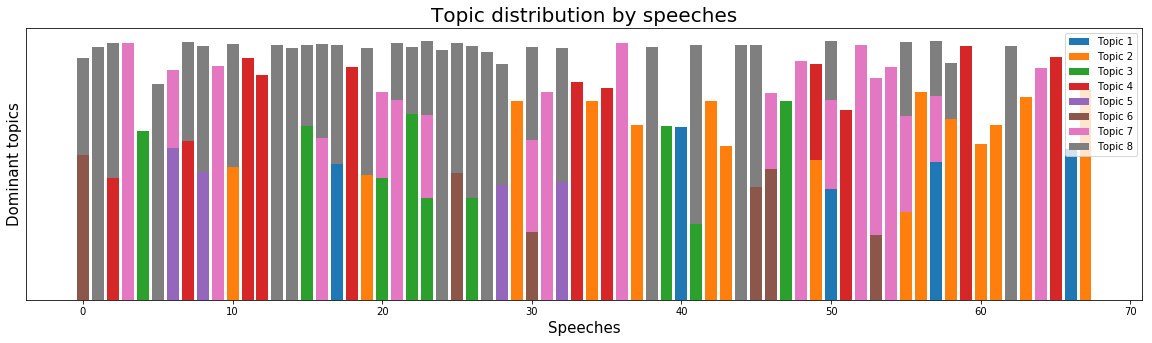

In [219]:
fld = 'romney'
#topic_order =  [int(indx[6:])-1 for indx in \
#                pd.DataFrame(df_topicdist[fld].sum(axis=0),columns=['Importance']).sort_values('Importance', ascending = False).index]
topic_order = np.arange(num_topics[fld])

plt.figure(figsize=(20,5))

bottom_bar = np.zeros(shape = len(corpus_tfidf[fld]))
for idx, topic_id in enumerate(topic_order) :
    distribution = np.array(df_topicdist[fld].iloc[:,topic_id])
    if bottom_bar.all == np.zeros :
        plt.bar(x=np.arange(len(corpus_tfidf[fld])), height=distribution, bottom=None, label = "Topic "+str(idx+1))
        bottom_bar = distribution
    else :
        plt.bar(x=np.arange(len(corpus_tfidf[fld])), height=distribution, bottom=bottom_bar, label = "Topic "+str(idx+1))
        bottom_bar += distribution
  
plt.xlabel("Speeches",fontsize=15)
plt.ylabel("Dominant topics",fontsize=15)
plt.title("Topic distribution by speeches", fontsize=20)
plt.yticks([])
plt.legend(loc='upper right')
plt.show()

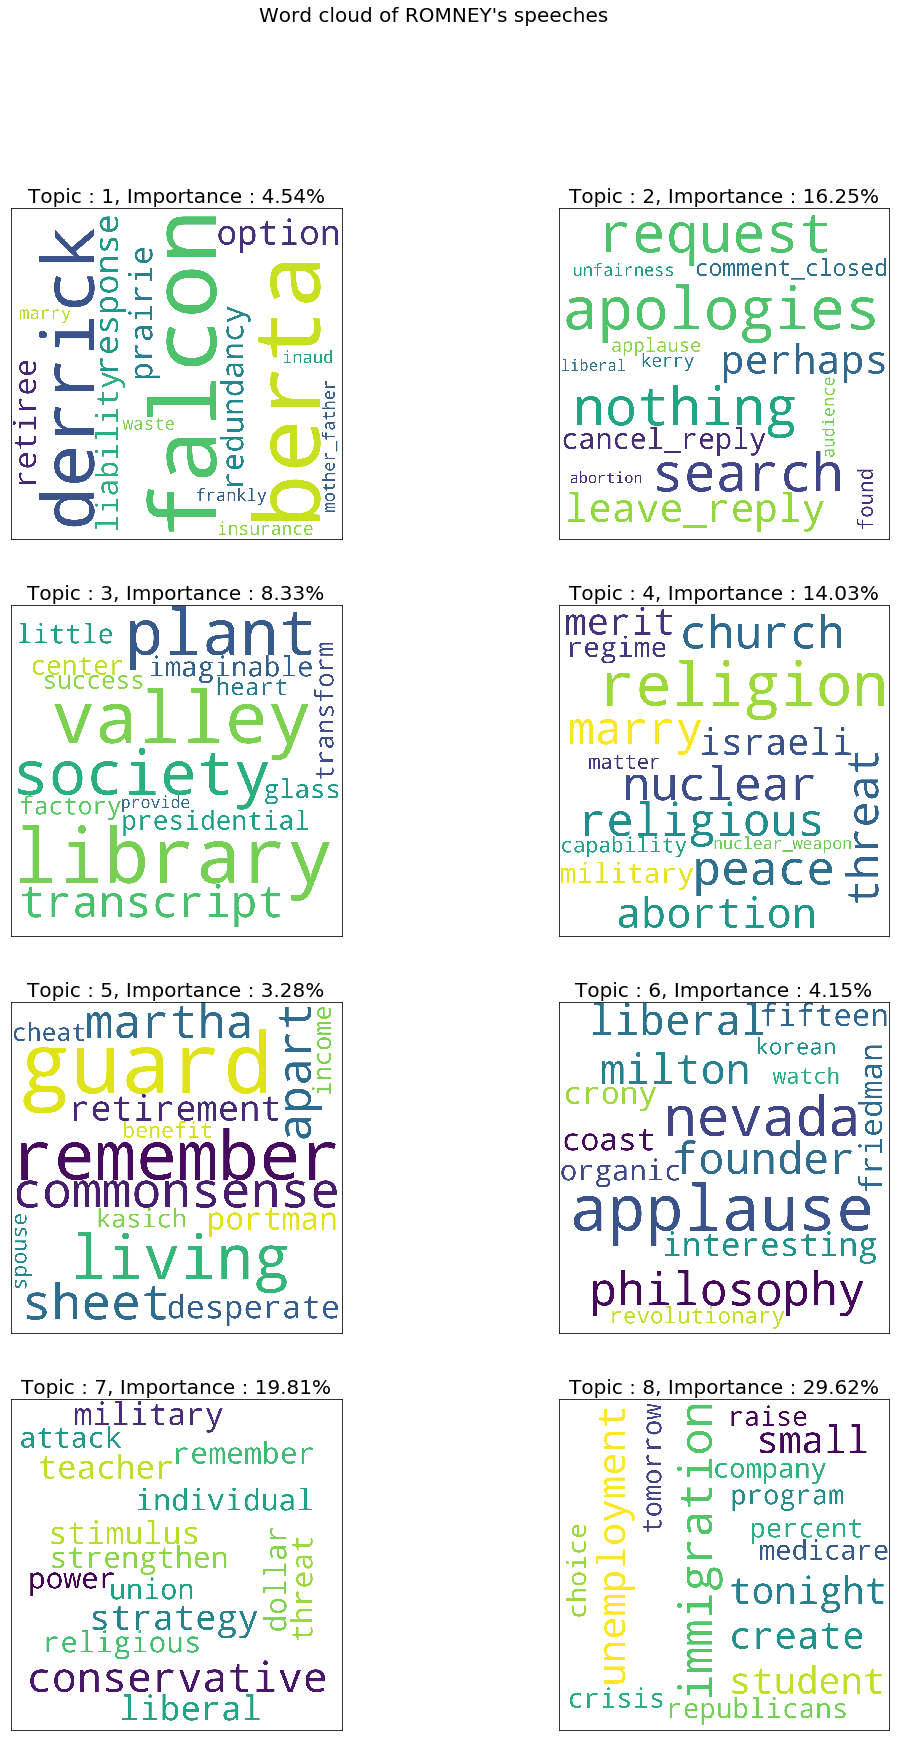

In [230]:
# Display all topics from Romney's speeches
fld = 'romney'

#topic_order =  [int(indx[6:])-1 for indx in \
#                pd.DataFrame(df_topicdist[fld].sum(axis=0),columns=['Importance']).sort_values('Importance', ascending = False).index]
topic_order = np.arange(num_topics[fld])

topics = lda[fld].show_topics(formatted=False, num_words = num_words)
topics = [[topic_order[id],topic] for id,topic in topics]

wordcloud = WordCloud(width=1200,height=1200,
                     background_color='white', min_font_size=10)
fig, ax = plt.subplots(int(np.ceil(num_topics[fld]/2)),2, figsize=(18,28),sharex=True,sharey=True)

for topic_id,content in topics :    
    fig.add_subplot(ax.flatten()[topic_id])
    topic_dict = dict(content)   
    wordcloud.generate_from_frequencies(topic_dict)
    plt.imshow(wordcloud)
    plt.xticks([])
    plt.yticks([])    
    plt.title("Topic : " + str(topic_id+1) + ", Importance : " + str(round(topic_imp[topic_id],2))+'%',fontsize=20)
    

plt.suptitle("Word cloud of " + fld.upper() + "'s speeches", fontsize=20)
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.margins(x=0,y=0)
plt.show()
    

In [132]:
# Visualize - LDA using pyLDAvis (Romney's speeches)
vis = dict()
fld='romney'
vis[fld] = pyLDAvis.gensim.prepare(lda[fld],corpus=corpus_tfidf[fld],dictionary=corpus_dict, mds = 'mmds')

In [133]:
# Print topics in Romney's speeches
print("Speech by ",fld)
vis[fld]

romney


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      32.287071        1       1 -0.010916  0.012551
6      23.088699        1       2  0.004845  0.008896
3      15.599525        1       3  0.008407 -0.003125
1       8.143713        1       4 -0.006476 -0.005140
2       8.095862        1       5  0.003485 -0.001110
5       4.474174        1       6  0.000015 -0.002372
0       4.413680        1       7 -0.001010 -0.004982
4       3.897270        1       8  0.001651 -0.004718, topic_info=     Category      Freq            Term     Total  loglift  logprob
term                                                               
7969  Default  0.000000       apologies  0.000000  30.0000  30.0000
7564  Default  0.000000         request  0.000000  29.0000  29.0000
2837  Default  0.000000          search  0.000000  28.0000  28.0000
1232  Default  0.000000         nothing  0.000000  27.0000  27.0000
2719  Default  0.000000         perhaps  0.000000  26.0000  26.0000
4016  Default  0.000000    cancel_reply  0.000000  25.0000  25.0000
783   Default  0.000000     leave_reply  0.000000  24.0000  24.0000
3219  Default  0.000000        applause  0.000000  23.0000  23.0000
2461  Default  0.000000  comment_closed  0.000000  22.0000  22.0000
2344  Default  0.000000           found  0.000000  21.0000  21.0000
7945  Default  0.000000          falcon  0.000000  20.0000  20.0000
8165  Default  0.000000           berta  0.000000  19.0000  19.0000
441   Default  0.000000        religion  0.000000  18.0000  18.0000
972   Default  0.000000          nevada  0.000000  17.0000  17.0000
6827  Default  0.000000         library  0.000000  16.0000  16.0000
1428  Default  0.000000    conservative  0.000000  15.0000  15.0000
1291  Default  0.000000         liberal  0.000000  14.0000  14.0000
7070  Default  0.000000           kerry  0.000000  13.0000  13.0000
2168  Default  0.000000           guard  0.000000  12.0000  12.0000
2934  Default  0.000000     immigration  0.000000  11.0000  11.0000
6333  Default  0.000000          valley  0.000000  10.0000  10.0000
2430  Default  0.000000        remember  0.000000   9.0000   9.0000
3787  Default  0.000000        audience  0.000000   8.0000   8.0000
7812  Default  0.000000      unfairness  0.000000   7.0000   7.0000
6836  Default  0.000000      philosophy  0.000000   6.0000   6.0000
2528  Default  0.000000         derrick  0.000000   5.0000   5.0000
4565  Default  0.000000        abortion  0.000000   4.0000   4.0000
6621  Default  0.000000        strategy  0.000000   3.0000   3.0000
5077  Default  0.000000           plant  0.000000   2.0000   2.0000
6058  Default  0.000000         veteran  0.000000   1.0000   1.0000
...       ...       ...             ...       ...      ...      ...
7105   Topic8  0.009275           smell  0.099001   0.8770  -8.2370
5480   Topic8  0.009403        disgrace  0.102738   0.8537  -8.2233
6235   Topic8  0.009152          dorene  0.100021   0.8534  -8.2504
1749   Topic8  0.009231     superiority  0.103113   0.8316  -8.2417
6110   Topic8  0.008736         refrain  0.098862   0.8186  -8.2969
277    Topic8  0.008735          bigger  0.098867   0.8184  -8.2970
7725   Topic8  0.008729          amidst  0.098902   0.8174  -8.2977
1007   Topic8  0.008728         bloated  0.098906   0.8173  -8.2977
4343   Topic8  0.008728   disappointing  0.098910   0.8172  -8.2978
3061   Topic8  0.008716           lofty  0.098980   0.8152  -8.2991
2547   Topic8  0.008658           motor  0.098527   0.8130  -8.3059
4187   Topic8  0.008657         hampton  0.098529   0.8129  -8.3060
2696   Topic8  0.008656     eligibility  0.098530   0.8128  -8.3060
251    Topic8  0.008699          bitter  0.099086   0.8121  -8.3011
242    Topic8  0.008697         granite  0.099097   0.8118  -8.3013
5985   Topic8  0.009871          spouse  0.113552   0.8023  -8.1747
162    Topic8  0.009296      everywhere  0.108865   0.7844  -8.2347
4520   Topic8  0.

## Analysis of Obama's speeches

In [271]:
# LDA - final model (Obama's speech)
fld = 'obama'
num_of_passes = 20
lda = dict(); num_topics = dict()
num_topics[fld] = 12
num_words = 15

lda[fld] = models.LdaModel(corpus_tfidf[fld], id2word=corpus_dict, num_topics=num_topics[fld], passes = num_of_passes,\
                        chunksize=100, random_state=123, update_every=1)
model_perplexity = lda_model.log_perplexity(corpus_tfidf[fld])
print("Model perplexity for {} is {}".format(fld,model_perplexity))




Model perplexity for obama is -16.705652151236652


In [272]:
# Analyse the topic distribution of speeches by Obama
fld='obama'
threshold = 10.0
columns = ["Topic " + str(i+1) for i in range(num_topics[fld])]
df_topicdist = dict()
df_topicdist[fld] = pd.DataFrame(columns=columns)
topic_dist = lda[fld][corpus_tfidf[fld]]
for indx, doc_dist in enumerate(topic_dist):
    row =  dict(doc_dist)  
    df_topicdist[fld].loc[indx] = [row[i]*100 if i in row.keys() and row[i]*100 > threshold else 0 for i in range(num_topics[fld])]
    


In [273]:
# Topic by Importance (based on contribution in each speech)
df_topic_imp = pd.DataFrame(df_topicdist[fld].sum(axis=0),columns=['Importance'])
df_topic_imp = df_topic_imp*100/df_topic_imp.sum(axis=0)
topic_imp = df_topic_imp.iloc[:,0]
topic_imp

Topic 1     79.794315
Topic 2      0.910189
Topic 3      0.955970
Topic 4      0.320612
Topic 5      1.161962
Topic 6      0.758824
Topic 7     11.162792
Topic 8      0.177377
Topic 9      0.451603
Topic 10     0.806770
Topic 11     0.809547
Topic 12     2.690041
Name: Importance, dtype: float64

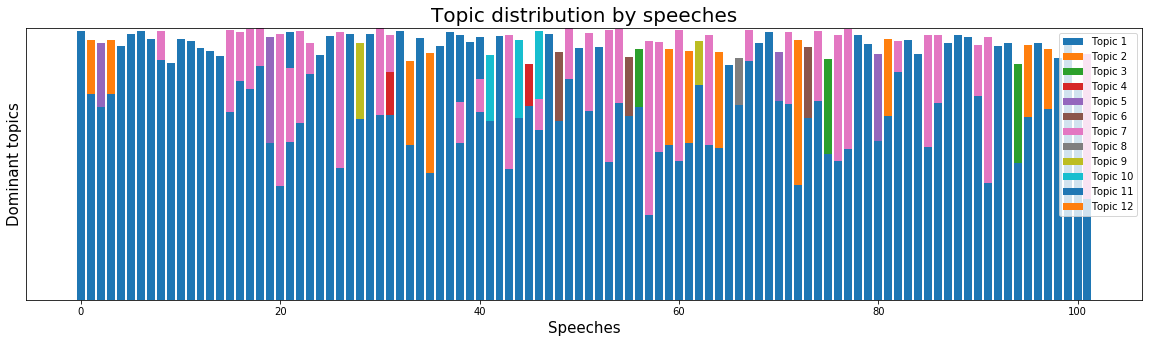

In [274]:
fld = 'obama'
#topic_order =  [int(indx[6:])-1 for indx in \
#                pd.DataFrame(df_topicdist[fld].sum(axis=0),columns=['Importance']).sort_values('Importance', ascending = False).index]
topic_order = np.arange(num_topics[fld])

plt.figure(figsize=(20,5))

bottom_bar = np.zeros(shape = len(corpus_tfidf[fld]))
for idx, topic_id in enumerate(topic_order) :
    distribution = np.array(df_topicdist[fld].iloc[:,topic_id])
    if bottom_bar.all == np.zeros :
        plt.bar(x=np.arange(len(corpus_tfidf[fld])), height=distribution, bottom=None, label = "Topic "+str(idx+1))
        bottom_bar = distribution
    else :
        plt.bar(x=np.arange(len(corpus_tfidf[fld])), height=distribution, bottom=bottom_bar, label = "Topic "+str(idx+1))
        bottom_bar += distribution
  
plt.xlabel("Speeches",fontsize=15)
plt.ylabel("Dominant topics",fontsize=15)
plt.title("Topic distribution by speeches", fontsize=20)
plt.yticks([])
plt.legend(loc='upper right')
plt.show()

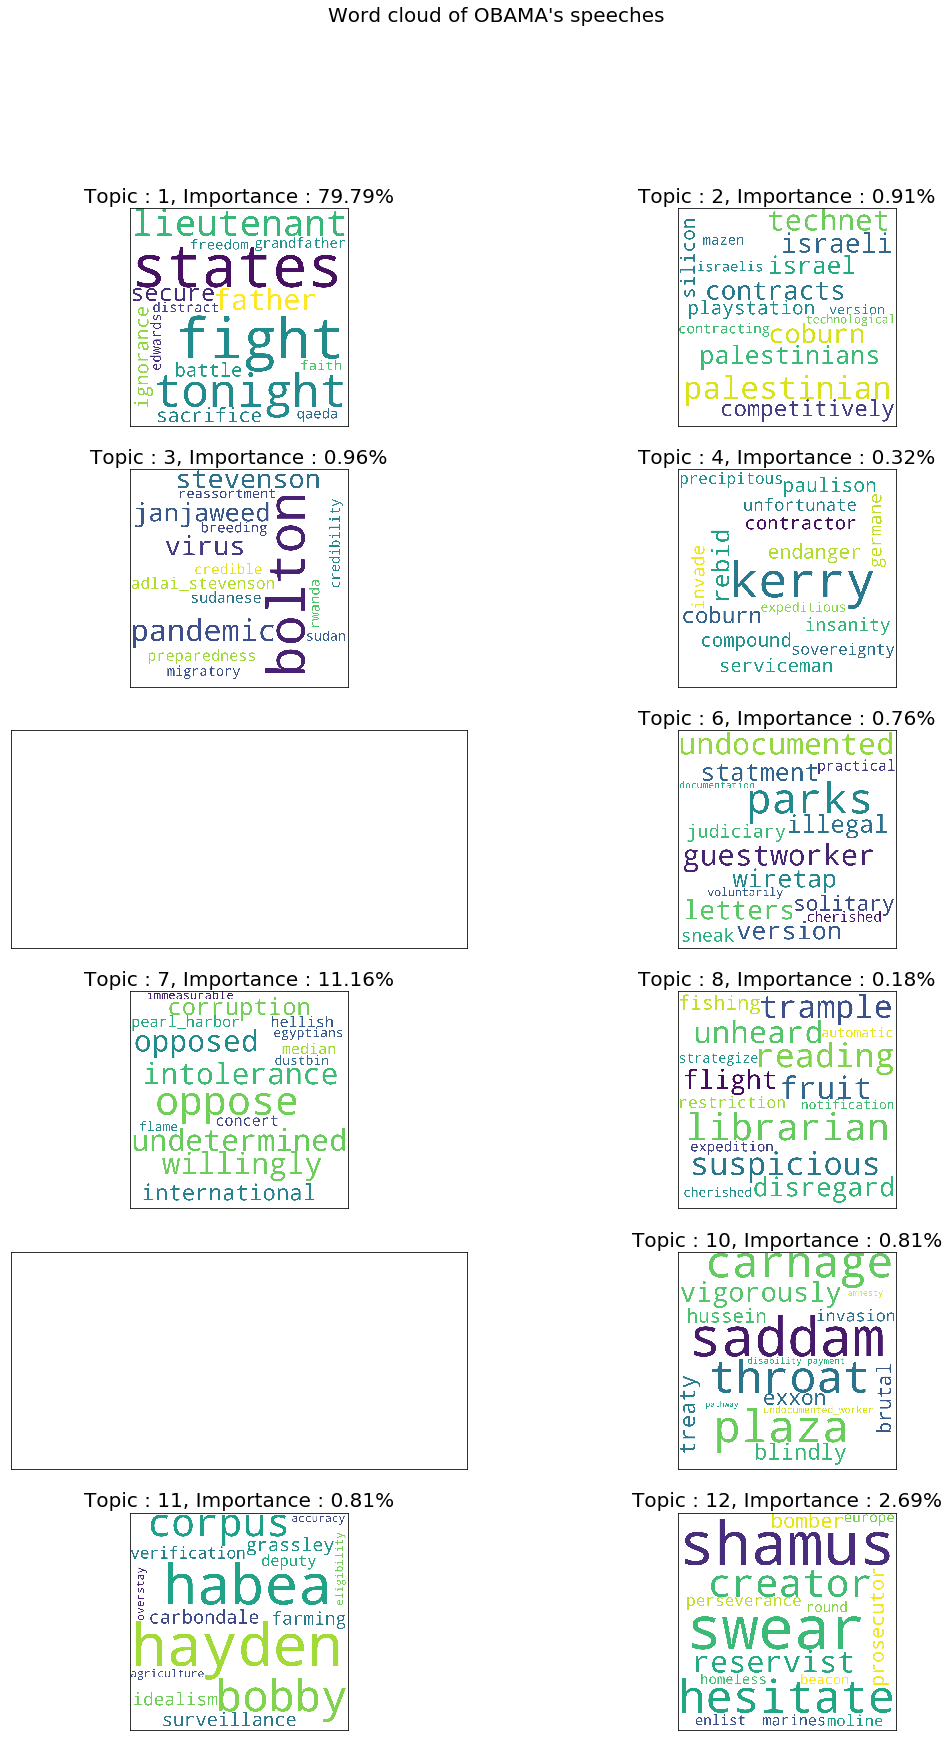

In [275]:
# Display all topics from Obama's speeches
fld = 'obama'

#topic_order =  [int(indx[6:])-1 for indx in \
#                pd.DataFrame(df_topicdist[fld].sum(axis=0),columns=['Importance']).sort_values('Importance', ascending = False).index]
topic_order = np.arange(num_topics[fld])

topics = lda[fld].show_topics(formatted=False, num_words = num_words)
topics = [[topic_order[id],topic] for id,topic in topics]


wordcloud = WordCloud(width=1200,height=1200,
                     background_color='white', min_font_size=10)
fig, ax = plt.subplots(int(np.ceil(num_topics[fld]/2)),2, figsize=(18,28),sharex=True,sharey=True)

for topic_id,content in topics :    
    fig.add_subplot(ax.flatten()[topic_id])
    topic_dict = dict(content)   
    wordcloud.generate_from_frequencies(topic_dict)
    plt.imshow(wordcloud)
    plt.xticks([])
    plt.yticks([])    
    plt.title("Topic : " + str(topic_id+1) + ", Importance : " + str(round(topic_imp[topic_id],2))+'%',fontsize=20)

plt.suptitle("Word cloud of " + fld.upper() + "'s speeches", fontsize=20)
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.margins(x=0,y=0)
plt.show()
    

In [276]:
# Visualize - LDA using pyLDAvis (Obama's speeches)
fld='obama'
vis[fld] = pyLDAvis.gensim.prepare(lda[fld],corpus=corpus_tfidf[fld],dictionary=corpus_dict, mds = 'mmds')

In [277]:
# Print topics in Obama's speeches
print(list(corpus_tfidf.keys())[1])
vis[list(corpus_tfidf.keys())[1]]

obama


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      74.056129        1       1 -0.005597  0.108385
6      12.823560        1       2  0.010202 -0.081771
11      2.770085        1       3 -0.012226 -0.004884
4       1.512067        1       4 -0.001766 -0.002022
9       1.356914        1       5  0.008431 -0.007639
10      1.273174        1       6 -0.001002 -0.002407
1       1.273093        1       7 -0.000839 -0.001962
2       1.218202        1       8 -0.001308 -0.002537
5       1.103450        1       9 -0.001455 -0.002318
8       0.955659        1      10 -0.000993 -0.002171
3       0.884031        1      11  0.007849  0.001479
7       0.773630        1      12 -0.001296 -0.002152, topic_info=     Category      Freq             Term     Total  loglift  logprob
term                                                                
7337  Default  1.000000           oppose  1.000000  30.0000  30.0000
7070  Default  0.000000            kerry  0.000000  29.0000  29.0000
7544  Default  1.000000     undetermined  1.000000  28.0000  28.0000
5943  Default  1.000000          opposed  1.000000  27.0000  27.0000
7273  Default  1.000000        willingly  1.000000  26.0000  26.0000
6806  Default  1.000000      intolerance  1.000000  25.0000  25.0000
4797  Default  0.000000       corruption  0.000000  24.0000  24.0000
2904  Default  0.000000    international  0.000000  23.0000  23.0000
7972  Default  0.000000     pearl_harbor  0.000000  22.0000  22.0000
2573  Default  0.000000            flame  0.000000  21.0000  21.0000
8069  Default  0.000000            mobil  0.000000  20.0000  20.0000
301   Default  0.000000        bloodiest  0.000000  19.0000  19.0000
1298  Default  0.000000            shove  0.000000  18.0000  18.0000
4480  Default  0.000000          warrior  0.000000  17.0000  17.0000
4986  Default  0.000000     immeasurable  0.000000  16.0000  16.0000
1368  Default  0.000000          dustbin  0.000000  15.0000  15.0000
6277  Default  0.000000          butcher  0.000000  14.0000  14.0000
3736  Default  0.000000          richard  0.000000  13.0000  13.0000
8257  Default  0.000000            ought  0.000000  12.0000  12.0000
2673  Default  0.000000           median  0.000000  11.0000  11.0000
3937  Default  0.000000     irrespective  0.000000  10.0000  10.0000
5800  Default  0.000000        wolfowitz  0.000000   9.0000   9.0000
3025  Default  0.000000        multitude  0.000000   8.0000   8.0000
6006  Default  0.000000         crucible  0.000000   7.0000   7.0000
1627  Default  0.000000          oppress  0.000000   6.0000   6.0000
5850  Default  0.000000          hellish  0.000000   5.0000   5.0000
1943  Default  0.000000         armchair  0.000000   4.0000   4.0000
1530  Default  0.000000          concert  0.000000   3.0000   3.0000
8221  Default  0.000000        egyptians  0.000000   2.0000   2.0000
952   Default  0.000000        mismanage  0.000000   1.0000   1.0000
...       ...       ...              ...       ...      ...      ...
8312  Topic12  0.001206       underwrite  0.085229   0.6035  -9.0277
6397  Topic12  0.001206       malevolent  0.085229   0.6035  -9.0277
3226  Topic12  0.001206        incubator  0.085229   0.6035  -9.0277
1687  Topic12  0.001206       promotions  0.085229   0.6035  -9.0277
1585  Topic12  0.001206         monarchy  0.085229   0.6035  -9.0277
4646  Topic12  0.001206   inbox_facebook  0.085229   0.6035  -9.0277
1689  Topic12  0.001206        brutality  0.085229   0.6035  -9.0277
6395  Topic12  0.001206    tyrannosaurus  0.085229   0.6035  -9.0277
1694  Topic12  0.001206         tanzania  0.085229   0.6035  -9.0277
1685  Topic12  0.001206        admirable  0.085229   0.6035  -9.0277
6389  Topic12  0.001206        unelected  0.085229   0.6035  -9.0277
1662  Topic12  0.001206          unclear  0.085229   0.6035  -9.0277
6402  Topic12  0.001206           rabbit  0.085229   0.6035  -9.0277
1683  Topic12  0.001206    